In [1]:
import os
import numpy 
from scipy import integrate, linalg 
from matplotlib import pyplot

# integrate plots into the notebook 
%matplotlib inline

In [3]:
Mainfoil = numpy.genfromtxt('../AeroPython/lessons/resources/MainFoil_N=50.csv', delimiter =',')
Flapfoil = numpy.genfromtxt('../AeroPython/lessons/resources/FlapFoil_N=50.csv', delimiter = ',')

In [5]:
Main_x, Flap_x = Mainfoil[:,0], Flapfoil[:,0]
Main_y, Flap_y = Mainfoil[:,1], Flapfoil[:,1]

N = numpy.size(Main_x)-1

numpy.size(Main_x) - 1,numpy.size(Flap_x) -1

(50, 50)

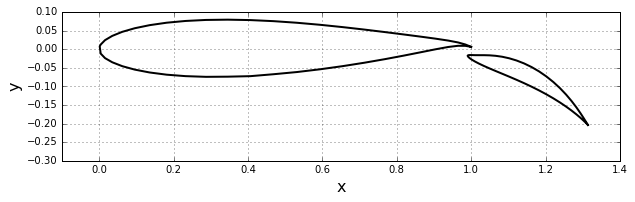

In [6]:
width =10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Main_x,Main_y,color='k', linestyle='-', linewidth=2)
pyplot.plot(Flap_x, Flap_y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);


In [7]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [8]:
Main_panels = numpy.empty(N, dtype = object)
Flap_panels = numpy.empty(N, dtype = object)
for i in range(N):
    Main_panels[i] = Panel(Main_x[i],Main_y[i],Main_x[i+1],Main_y[i+1])
    Flap_panels[i] = Panel(Flap_x[i],Flap_y[i],Flap_x[i+1],Flap_y[i+1])

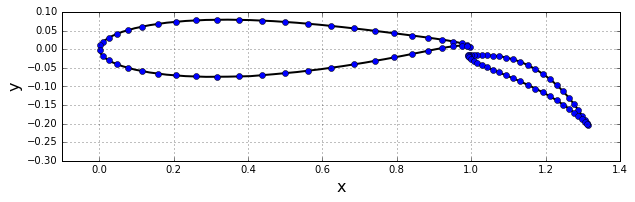

In [9]:
width= 10 
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Main_x,Main_y,color='k', linestyle = '-', linewidth=2)
pyplot.plot(Flap_x,Flap_y,color='k', linestyle = '-', linewidth=2)
for i in range(N-1): 
    pyplot.plot(Main_panels[i].xc, Main_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
    pyplot.plot(Flap_panels[i].xc, Flap_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);


In [17]:
class Freestream: 
    """
    Freestream conditions. 
    """
    def __init__(self, u_inf =1.0, alpha =0.0):
        """
        Sets the freestream speed and angle (in degrees). 
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0. 
        alpha: float, optional
            Angle of attack in degrees; 
            default: 0.0. 
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0

freestream = Freestream(u_inf=1.0, alpha = 0.0)

In [18]:
def integral(x, y, panel, dxdk, dydk): 
    """
    Evaluates the contribution from a panel at a given point. 
    
    Parameters 
    ----------
    x: float
        x-coordinate of target point. 
    y: float 
        y-coodrinate of target point. 
    panel: Panel object 
        Panel whose contribution is evaluated. 
    dxdk: float 
        Value of the derivative of x in a certain direction. 
    dydk: float 
        Value of the derivative of y in a certain direction. 
    
    Returns 
    -------
    Contribution fro the panel at a given point (x, y)
    """
    def integrand(s): 
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
               / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                 + (y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [19]:
def source_contribution_normal(panels): 
    """
    Builds the source contribution matrix for the normal velocity. 
    
    Parameters
    -----------
    panels: 1D array of Panel objects
        list of panels. 
    
    Returns 
    -------
    A: 2D Numpy array of floats
        Source contribution matrix
    """
    A = numpy.empty((panels.size, panels.size), dtype = float)
    # source contribution on a panel from itself 
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others 
    for i, panel_i in enumerate(panels): 
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                              panel_j, 
                                              numpy.cos(panel_i.beta), 
                                              numpy.sin(panel_i.beta))
    return A

In [20]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A


In [21]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b


In [22]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A



In [27]:
A_source = source_contribution_normal(Main_panels)
B_vortex = vortex_contribution_normal(Main_panels)

In [28]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b


In [31]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(Main_panels, freestream)

In [32]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

In [33]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [46]:

strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(Main_panels):
    panel.sigma = strengths[i]
    
gamma = strengths[-2]

compute_tangential_velocity(Main_panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(Main_panels, freestream)

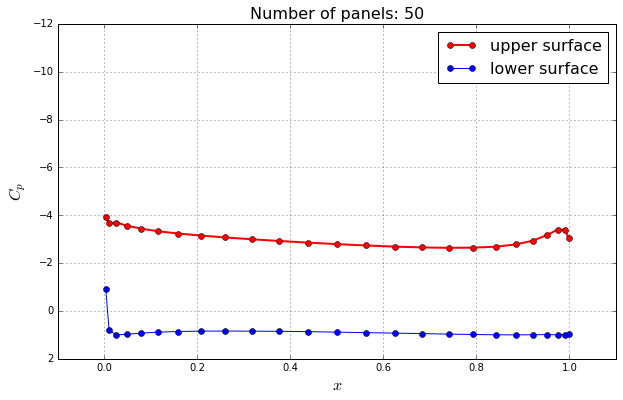

In [48]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in Main_panels if panel.loc == 'upper'],
            [panel.cp for panel in Main_panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in Main_panels if panel.loc == 'lower'],
            [panel.cp for panel in Main_panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(2.0, -12.0)
pyplot.title('Number of panels: {}'.format(Main_panels.size), fontsize=16);

In [49]:

panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=Main_panels[i]
    elif i>=N:
        panels[i]=Flap_panels[i-N]
print( panels[2].cp)

-3.40172944779


In [50]:
print(panels[N+9].cp)

0.0


In [51]:
lift, drag = 0, 0

for panel in panels:
    lift -= panel.cp*numpy.sin(panel.beta)*panel.length
    drag += panel.cp*numpy.cos(panel.beta)*panel.length

In [52]:
print(lift)

3.86784516685


In [53]:
print(drag)

0.0785098386712


In [54]:
lift_theoretical = 3.739
error_1 = abs(lift-lift_theoretical)
print( error_1)

0.128845166851
